In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
def AddImage(path):
  img = Image.open(path)
  img = img.resize((25,25))
  img = img.convert('L')
  x = np.array(img, np.float32)
  x = x.reshape(-1,625)
  x = x / 255
  return x[0]
     

In [ ]:
pathBig = '/content/drive/My Drive/Нейронки/lab2/bigA/01_00_00_0{0}.png'
pathSmall = '/content/drive/My Drive/Нейронки/lab2/smallA/00_00_00_0{0}.png'
x_general = []
y_general = []
for i in range(100):
  x_general.append(AddImage(pathBig.format(str(i).zfill(3))))
  y_general.append(1)
for i in range(100):
  x_general.append(AddImage(pathSmall.format(str(i).zfill(3))))
  y_general.append(0)

In [ ]:
x_general = np.array(x_general)
y_general = np.array(y_general)
x_train, x_test, y_train, y_test = train_test_split(x_general, y_general, test_size=0.33, random_state=100)

In [ ]:
def Hebba(weight, x0, y, e):
    #Обучает вес по правилу хебба
    alpha = 0.1
    return weight - alpha * x0 * (y - e)
    
def sigmoid(x):
    return 1 if x > 0 else 0

In [ ]:
class Neuron:
    def __init__(self, weights, bias =1, biasWigth = 1):
        self.Weights = weights
        self.DeltaWeights = np.zeros(len(weights))
        self.Bias = bias
        self.Beta = 0
        self.BiasWigth = biasWigth
    
    def feedforward(self, inputs):
        self.LastInput = inputs
        total = np.dot(self.Weights, inputs) + self.Bias * self.BiasWigth
        self.LastRezult = total
        return sigmoid(total)
    
    
    def WeightCorrection(self, function, y, e):
        for i in range(len(self.Weights)):
                self.Weights[i] = function(self.Weights[i], self.LastInput[i], y, e)
                
        self.BiasWigth = function(self.BiasWigth, self.Bias, y, e)

In [ ]:
class HebbNetwork:
    def __init__(self, neuronsCountArray, eps = 0.1):
        self.Eps = eps
        self.T = 0
        self.L = []
        self.Neurons = {}
        for i in range(1, len(neuronsCountArray)):
          self.Neurons[i] = []
          for j in range(neuronsCountArray[i]):
            self.Neurons[i].append(Neuron(np.random.rand(neuronsCountArray[i-1]), 1)) 
    
    def fit(self, X, y, tmax = 20):
        t = 1
        self.CalculateLoss(X,y)
        while self.L[len(self.L)-1] > self.Eps and t < tmax:
            print(self.L[-1],t)
            for i in range(len(X)):
                e = self.feedforward(X[i])
                if e != y[i]:
                    self.WeightCorrection(e, y[i])
                    self.CalculateLoss(X,y)
                    t+=1
        print("network was learned for",t,"generations")
        self.T = t
    
    def predict(self, data):
        return self.feedforward(data)
        
    def feedforward(self, inputs):
        y = [neuron.feedforward(inputs) for neuron in self.Neurons[1]]
        for i in self.Neurons:
          if i == 1:
            continue
          else:
            y = [neuron.feedforward(y) for neuron in self.Neurons[i]]
        
        return y[0]

    def CalculateLoss(self, x,y):
      loss = 0
      for j in range(len(x)):
        e = self.feedforward(x[j])
        if e != y[j]:
          loss +=1
      self.L.append(loss/len(x))
      return loss/len(x)


    def WeightCorrection(self,y,e):
        function = Hebba
        for i in self.Neurons:
          [neuron.WeightCorrection(function,y,e) for neuron in self.Neurons[i]]


In [ ]:
perceptron = HebbNetwork([625, 14, 7, 3, 1], 0.4)
perceptron.fit(x_train,y_train)

0.47761194029850745 1
network was learned for 60 generations


testLoss:  0.5454545454545454


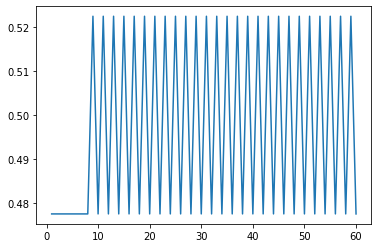

In [ ]:

print("testLoss: ",perceptron.CalculateLoss(x_test, y_test))
plt.plot(range(1,perceptron.T+1), perceptron.L[:perceptron.T])


0.5 1
0.5 3
0.5 5
0.5 7
0.5 9
0.5 11
0.5 13
0.5 15
0.75 17
0.5 19
network was learned for 22 generations
testLoss:  0.75


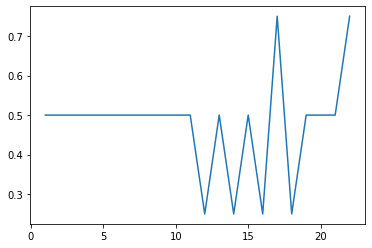

In [ ]:
mx = [[0,0], [0,1], [1,0], [1,1]]
my = [0, 1, 1, 0]
perceptron = HebbNetwork([2, 1], 0.2)
perceptron.fit(mx,my)
print("testLoss: ",perceptron.CalculateLoss(mx, my))
plt.plot(range(1,perceptron.T+1), perceptron.L[:perceptron.T])

In [ ]:
print([perceptron.predict(i) for i in mx])

[0, 0, 0, 1]


In [ ]:
def sigmoid(x):
    #Сигмоидная функция активации: f(x) = 1 / (1 + e^(-x))
    return 1 / (1 + np.exp(-x))
    #return 1 if x > 0 else 0

def dersigmoid(s):
  return sigmoid(s) * (1 - sigmoid(s))

class NetworkGradient:
    def __init__(self, neuronsCountArray, eps = 0.1):
        '''
        neuronsCountArray example [25, 14, 7, 3, 1] where each number mean
         a count of neurons in the layer
        ''' 
        self.Eps = eps
        self.T = 0
        self.L = []
        self.Neurons = {}
        for i in range(1, len(neuronsCountArray)):
          self.Neurons[i] = []
          for j in range(neuronsCountArray[i]):
            self.Neurons[i].append(Neuron(np.random.randint(-5,5,neuronsCountArray[i-1]), 1)) 
    
    def fit(self, X, y):
        self.T = 1
        self.CalculateLoss(X,y)
        while self.L[len(self.L)-1] > self.Eps and self.T < 25000:
          n_rule = np.random.randint(0, len(X))
          e = self.feedforward(X[n_rule])
          if any(np.abs(self.lossFunction(y[n_rule],e)) > self.Eps):
              self.WeightCorrection(y[n_rule])
              self.CalculateLoss(X,y)
              self.T+=1
        print("network was learned for",self.T,"generations")
    
    def predict(self, data):
        return self.feedforward(data)
        
    def feedforward(self, inputs):
        y = [neuron.feedforward(inputs) for neuron in self.Neurons[1]]
        for i in self.Neurons:
          if i == 1:
            continue
          else:
            y = [neuron.feedforward(y) for neuron in self.Neurons[i]]
        
        return y

    def lossFunction(self, e, y):
      return np.square(e - y)

    def CalculateLoss(self, x,y):
      loss = 0
      for j in range(len(x)):
        e = self.feedforward(x[j])
        loss += self.lossFunction(e, y[j])
      
      self.L.append(sum(loss)/len(x))
      if self.T %1000 == 0:
          print("T",self.T,"Loss",self.L[len(self.L)-1])
      return sum(loss)/len(x)

    def CalculateAcc(self, x,y):
      loss = 0
      for j in range(len(x)):
        e = self.feedforward(x[j])
        loss += 1 if np.abs(e - y[j]) < 0.3 else 0
      
      self.Acc.append(loss/len(x))

    def WeightCorrection(self,e):#(e-y)*e*(2-e)
      lam = 0.1
      for neurone in self.Neurons[len(self.Neurons)]:
        y = sigmoid(neurone.LastRezult)
        beta = (y - e) * dersigmoid(neurone.LastRezult)
        neurone.Weights = neurone.Weights - np.dot(lam * beta,neurone.LastInput)
        beta1 = beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, len(self.Neurons)-1)


      self.BackLayerPropagation(len(self.Neurons)-1)
    
    def BackLayerPropagation(self, layerIndex):
      lam = 0.1
      if layerIndex == 0:
        return
      #Для всех слоёв не считая начального
      for neurone in self.Neurons[layerIndex]:
        neurone.Weights = neurone.Weights - np.dot(lam * neurone.Beta, neurone.LastInput)
        beta1 = neurone.Beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, len(self.Neurons)-1)
        
      
      self.BackLayerPropagation(layerIndex-1) 
      for neurone in self.Neurons[layerIndex]:     
        neurone.Beta = 0


    def AddBetaInPreviousLayer(self, beta, layerIndex):
      if layerIndex == 0:
        return
      for i in range(len(self.Neurons[layerIndex])):
        self.Neurons[layerIndex][i].Beta += beta[i]
    


In [ ]:
perceptron = NetworkGradient([625, 25, 5, 1], 0.35)
perceptron.fit(x_train,y_train)

network was learned for 845 generations


In [ ]:
print(perceptron.L[-1])

0.3485248034986735


testLoss:  0.39426049871969143


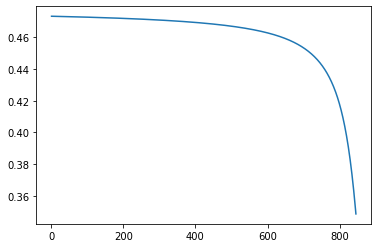

In [ ]:
print("testLoss: ",perceptron.CalculateLoss(x_test, y_test))
plt.plot(range(1,perceptron.T+1), perceptron.L[:perceptron.T])
plt.show()

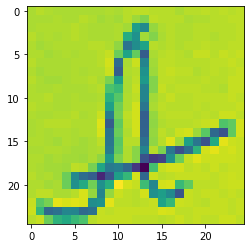

In [ ]:
plt.imshow(x_train[0].reshape(25,25))

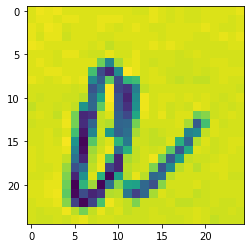

In [ ]:
plt.imshow(x_test[0].reshape(25,25))